### Import Library

In [56]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
import random
from PIL import Image

### Laod Dataset

In [6]:
train_dir='../datasets/Training'
test_dir='../datasets/Testing'

### Data Understanding

Cek kelas tersedia

In [7]:
classes = os.listdir(train_dir)
print(f"Kelas yang tersedia: {classes}")

Kelas yang tersedia: ['glioma', 'meningioma', 'notumor', 'pituitary']


Jumlah gambar per kelas

In [40]:
train_counts = {}
test_counts = {}

for cls in classes:
    train_path = os.path.join(train_dir, cls)
    test_path = os.path.join(test_dir, cls)

    train_counts[cls] = len(os.listdir(train_path))
    test_counts[cls] = len(os.listdir(test_path))

print("Jumlah Gambar di Train Set:")
print(train_counts)

print("\nJumlah Gambar di Test Set:")
print(test_counts)

Jumlah Gambar di Train Set:
{'glioma': 1321, 'meningioma': 1339, 'notumor': 1595, 'pituitary': 1457}

Jumlah Gambar di Test Set:
{'glioma': 300, 'meningioma': 306, 'notumor': 405, 'pituitary': 300}


Buat Dataframe

In [47]:
df = pd.DataFrame({
    'Class': classes,
    'Train': [train_counts[cls] for cls in classes],
    'Test': [test_counts[cls] for cls in classes]
})

Distribusi Persentase Gamber per Kelas (Train Set)

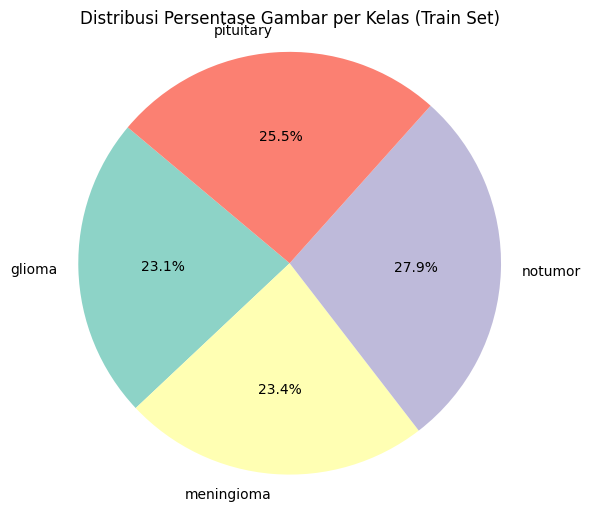

In [53]:
plt.figure(figsize=(6,6))
plt.pie(df['Train'], labels=df['Class'], autopct='%1.1f%%', startangle=140, colors=sns.color_palette("Set3"))
plt.title("Distribusi Persentase Gambar per Kelas (Train Set)")
plt.axis('equal')
plt.show()

Distribusi Persentase Gambar per Kelas (Test Set)

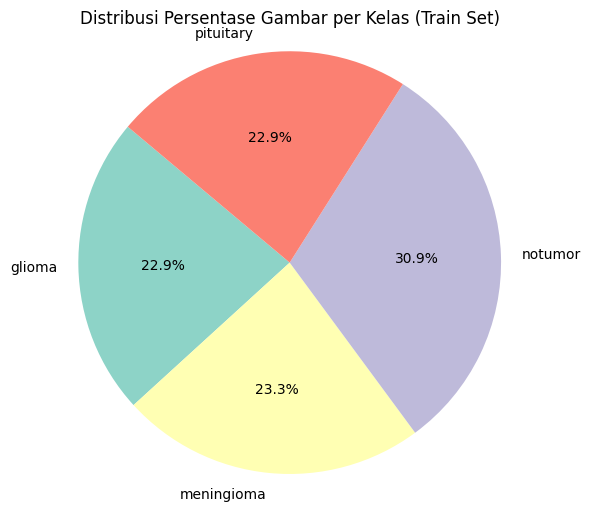

In [52]:
plt.figure(figsize=(6,6))
plt.pie(df['Test'], labels=df['Class'], autopct='%1.1f%%', startangle=140, colors=sns.color_palette("Set3"))
plt.title("Distribusi Persentase Gambar per Kelas (Train Set)")
plt.axis('equal')
plt.show()

Distribusi Gambar per Kelas (Train vs Test)

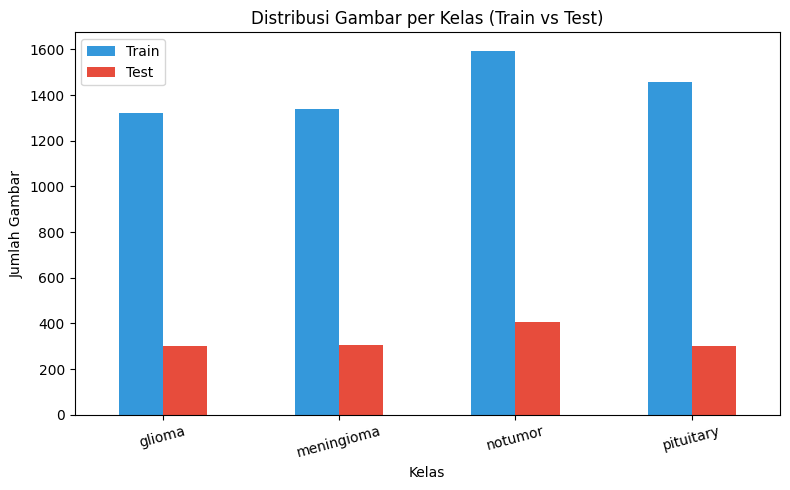

In [54]:
df.set_index('Class')[['Train', 'Test']].plot(kind='bar', figsize=(8,5), color=['#3498db', '#e74c3c'])
plt.title('Distribusi Gambar per Kelas (Train vs Test)')
plt.xlabel('Kelas')
plt.ylabel('Jumlah Gambar')
plt.xticks(rotation=15)
plt.tight_layout()
plt.show()

Visualisasi sample gambar

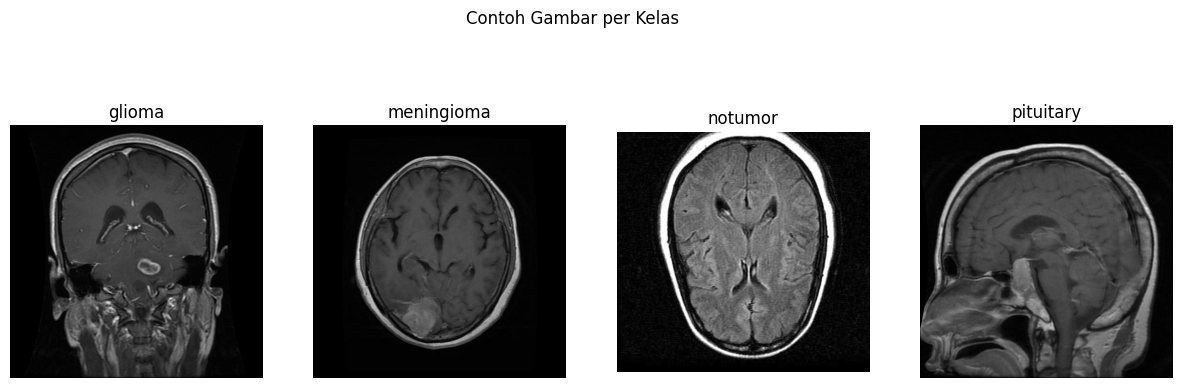

In [39]:
fig, axes = plt.subplots(1, 4, figsize=(15, 5))
for i, cls in enumerate(classes):
    path = os.path.join(train_dir, cls)
    img = random.choice(os.listdir(path))
    img_path = os.path.join(path, img)
    image = Image.open(img_path)
    axes[i].imshow(image)
    axes[i].set_title(cls)
    axes[i].axis('off')
plt.suptitle("Contoh Gambar per Kelas")
plt.show()

### Data Preprocessing

Image size

In [57]:
img_size = (150, 150)
batch_size = 32

Augmentasi data training

In [58]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    zoom_range=0.1,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True
)

Validasi test

In [59]:
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical'
)

Found 5712 images belonging to 4 classes.
Found 1311 images belonging to 4 classes.


### Modeling

Arsitektur model

In [ ]:
model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(150,150,3)),
    BatchNormalization(),
    MaxPooling2D(2,2),

    Conv2D(64, (3,3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2,2),

    Conv2D(128, (3,3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2,2),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(4, activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Callback model

In [ ]:
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

Training model

In [ ]:
history = model.fit(
    train_generator,
    epochs=20,
    validation_data=test_generator,
    callbacks=[early_stop]
)